In [0]:
import warnings
warnings.filterwarnings('ignore')

## Download the data

In [0]:
from IPython.display import clear_output
!curl --remote-name-all https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-2988{/ud-treebanks-v2.4.tgz,/ud-documentation-v2.4.tgz,/ud-tools-v2.4.tgz}
!rm ud-documentation-v2.4.tgz
!rm ud-tools-v2.4.tgz
# Data for EMBEDDINGS
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz -O ru.gz
clear_output()

In [0]:
# unzip external embeddings
import gzip
import shutil
with gzip.open('/content/ru.gz', 'rb') as f_in:
    with open('file.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


In [4]:
LANGUAGE = 'UD_Russian-GSD'
import os
import tarfile

def language_files(members):
    for tarinfo in members:
        if LANGUAGE in os.path.splitext(tarinfo.name)[0]:
          print(os.path.splitext(tarinfo.name)[0])
          yield tarinfo

tar = tarfile.open("/content/ud-treebanks-v2.4.tgz")
tar.extractall(members=language_files(tar))
tar.close()

ud-treebanks-v2.4/UD_Russian-GSD
ud-treebanks-v2.4/UD_Russian-GSD/README
ud-treebanks-v2.4/UD_Russian-GSD/ru_gsd-ud-train
ud-treebanks-v2.4/UD_Russian-GSD/ru_gsd-ud-dev
ud-treebanks-v2.4/UD_Russian-GSD/ru_gsd-ud-dev
ud-treebanks-v2.4/UD_Russian-GSD/ru_gsd-ud-test
ud-treebanks-v2.4/UD_Russian-GSD/ru_gsd-ud-test
ud-treebanks-v2.4/UD_Russian-GSD/ru_gsd-ud-train
ud-treebanks-v2.4/UD_Russian-GSD/stats
ud-treebanks-v2.4/UD_Russian-GSD/LICENSE


## Constants

In [0]:
PATH_TO_TRAIN_DATA = '/content/ud-treebanks-v2.4/UD_Russian-GSD/ru_gsd-ud-train.conllu'
PATH_TO_TEST_DATA = '/content/ud-treebanks-v2.4/UD_Russian-GSD/ru_gsd-ud-test.conllu'
EPOCHS = 50
LEARNING_RATE = 0.001

## Train data preprocessing. Parse words and tags. Convert the train set to numbers and separate text from labels. 

In [0]:
import string 

word_tag_mapping = {}
word_forms_to_word = {}
word_to_index = {}
tag_to_index = {}

word_to_index['-PAD-'] = 0
word_to_index['-OOV-'] = 1 # word not in vocabulary
tag_to_index['-PAD-'] = 0
tag_to_index['-OOV-'] = 1

train_data_indexed = []
train_labels_indexed = []

def process_train_line(line, word_idx, tag_idx):
  """
  param: line: input line from the labeled data: "1	Главная	главный	ADJ	JJL	Case=Nom|Degree=Pos|Gender=Fem|Number=Sing	2	amod	_	_"
  param: word_idx: smallest free integer for word numeration
  param: tag_idx: smallest free integer for tag numeration
  return: next free word_idx and tag_idx
  """
  l = line.split()
  word, word_form, tag = l[2], l[1], l[3]
  
  
#   punct_tags = ['&#39;&#39;', '--', '``', '.,', 'APOSTROPHE']
#   if tag in string.punctuation or tag in punct_tags:
#     tag = 'PUNCT'
  
  if not word in word_tag_mapping: # если такого слова еще нет в словаре всевозможных слов и их тегов, добавим
    word_tag_mapping[word] = tag
  if not word in word_forms_to_word:
    word_forms_to_word[word_form] = word
  if not word in word_to_index:
    word_to_index[word] = word_idx
    word_idx += 1
  if not tag in tag_to_index:
    tag_to_index[tag] = tag_idx
    tag_idx += 1
  
  sentence_data.append(word_to_index[word])
  sentence_tags.append(tag_to_index[tag])
  
  return word_idx, tag_idx
  
  
f = open(PATH_TO_TRAIN_DATA)
line = f.readline()

word_idx, tag_idx = 2, 2
sentence_data, sentence_tags = [], []
while line:
  if ('sent_id' in line) or ('text' in line) or len(line)<4:
    if len(sentence_data)>0:
      train_data_indexed.append(sentence_data)
      train_labels_indexed.append(sentence_tags)
    sentence_data, sentence_tags = [], []
  else: 
    word_idx, tag_idx = process_train_line(line, word_idx, tag_idx)
    
  line = f.readline()
f.close()

## Test data preprocessing

In [0]:
f = open(PATH_TO_TEST_DATA)
line = f.readline()

test_data_indexed = []
y_test = []

def process_test_line(line):
  l = line.split()
  word, tag = l[2], l[3]
  try:
    sentence_data.append(word_to_index[word])
  except KeyError:
    sentence_data.append(word_to_index['-OOV-'])
  
  try:
    sentence_tags.append(tag_to_index[tag])
  except: 
    sentence_tags.append(tag_to_index['-OOV-'])
  
sentence_data, sentence_tags = [], []
while line:
  if ('sent_id' in line) or ('text' in line) or len(line)<4:
    if len(sentence_data)>0:
      test_data_indexed.append(sentence_data)
      y_test.append(sentence_tags)
    sentence_data, sentence_tags = [], []
  else: 
    process_test_line(line)
  line = f.readline()
  
f.close()

## Fill external embeddings

In [0]:
import numpy as np

external_embeddings = {}
f = open('/content/file.txt')
line = f.readline()
while line:
    line = f.readline().split()
    if len(line)>2:
      word = line[0]
      v = np.array(line[1:]).astype('float32')
      external_embeddings[word] = v
f.close()

In [0]:
EMB_LEN = len(v)

## Data preprocessing. Padding on sentenses - Encoding of the data to be feed to neural network.

In [10]:
# compute the lenth of the longest sequence in the dataset
MAX_LENGTH = len(max(train_data_indexed, key=len))

# make all sequences the same size
from keras.preprocessing.sequence import pad_sequences
 
train_data_indexed = pad_sequences(train_data_indexed, maxlen=MAX_LENGTH, padding='post')
train_labels_indexed = pad_sequences(train_labels_indexed, maxlen=MAX_LENGTH, padding='post')
 
test_data_indexed = pad_sequences(test_data_indexed, maxlen=MAX_LENGTH, padding='post')
y_test = pad_sequences(y_test, maxlen=MAX_LENGTH, padding='post')

Using TensorFlow backend.


## Split train data to train and validation sets

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_data_indexed, train_labels_indexed, test_size=0.2)

## One hot encode features

In [0]:
import numpy as np
from keras.utils import to_categorical

# one-hot encode the tags labels
one_hot_train = to_categorical(y_train, len(tag_to_index))
one_hot_valid = to_categorical(y_valid, len(tag_to_index))
one_hot_test = to_categorical(y_test, len(tag_to_index))

## Model evaluation metrics

In [0]:
def eval_one_hot(y_true, y_pred):
  y_true_class = np.argmax(y_true, axis = -1)
  y_pred_class = np.argmax(y_pred, axis = -1)
  
  correct, total = 0, 0
  correct_sentenses = 0
  
  for i in range(y_true_class.shape[0]):
    try:
      idx = np.where(y_true_class[i] == 0)[0][0]
    except IndexError:
      idx = len(y_true_class[i])
    matches = np.sum(y_true_class[i][:idx] == y_pred_class[i][:idx])
    correct += matches
    total += idx
    if matches == idx:
      correct_sentenses += 1
  
  return correct/total, correct_sentenses/y_true.shape[0]
  

## Assemble the model with trainable embeddings

In [0]:
# network architecture
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, Embedding, Activation
from keras.optimizers import Adam
from keras.regularizers import l2
 
VOCAB_SIZE = len(word_to_index)
TAG_VOCAB_SIZE = len(tag_to_index)
  
def create_model():  
  model = Sequential([
    InputLayer(input_shape=(MAX_LENGTH, )), 
    Embedding(VOCAB_SIZE, 64),
    Bidirectional(LSTM(256, return_sequences=True)), 
    Dense(TAG_VOCAB_SIZE),
    Activation('softmax')
  ])

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(LEARNING_RATE), metrics = ['accuracy'])
  
  return model

## Train the model with embeddings

In [15]:
def batch (X_train, y_train, size = 128):
  """
  creates batches for training the model
  """
  N = y_train.shape[0]
  i = 0
  while i<N:
    if i+size<N:
      yield X_train[i:i+size], y_train[i:i+size]
    else: 
      yield X_train[i:], y_train[i:]
    i+=size
    
def train_step(model, X_train, y_train):
  """
  one step of training the model process
  return: loss, words accuracy and sentences accuracy for training data
  """
  N = 0
  t_loss, t_acc_word, t_acc_sent = 0,0,0
  for x, y in batch (X_train, y_train, size = 128):
    N += 1
    t_loss += model.train_on_batch(x, y)[0]
  
    # calculate accuracy on train set
    predictions = model.predict(x)
    a_w, a_s = eval_one_hot(y, predictions)
    t_acc_word += a_w
    t_acc_sent += a_s
    
  return t_loss/N, t_acc_word/N, t_acc_sent/N




def train(model, X_train, y_train, X_valid = None, y_valid = None, epochs = EPOCHS, verbose = True):
    """
    function to train the model
    return history of training loss, words accuracy for training and validation 
    sets, sentences accuracy for training and validation sets
    """
    train_loss, train_acc_word, valid_acc_word, train_acc_sent, valid_acc_sent = [], [], [], [], []
    for epoch in range(epochs):
      t_metrics = train_step(model, X_train, y_train)
      
      # validation accuracy
      if X_valid is not None:
        predictions = model.predict(X_valid)
        v_metrics = eval_one_hot(y_valid, predictions)
        valid_acc_word.append(v_metrics[0])
        valid_acc_sent.append(v_metrics[1]) 
        if verbose:
          print(f'Epoch {epoch} train loss: {t_metrics[0]} train acc word: {t_metrics[1]} train acc sentence: {t_metrics[2]}  valid acc word: {v_metrics[0]} valid acc sentence: {v_metrics[1]}')
      
      elif verbose: 
        print(f'Epoch {epoch} train loss: {t_metrics[0]} train acc word: {t_metrics[1]} train acc sentence: {t_metrics[2]}')
      
      # append to history
      train_loss.append(t_metrics[0])
      train_acc_word.append(t_metrics[1])
      train_acc_sent.append(t_metrics[2])
      
    return train_loss, train_acc_word, valid_acc_word, train_acc_sent, valid_acc_sent

model = create_model()
train_loss, train_acc_word, valid_acc_word, train_acc_sent, valid_acc_sent = train(model, X_train, one_hot_train, X_valid, one_hot_valid, verbose = True)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 0 train loss: 1.1673982954025268 train acc word: 0.04681402913777923 train acc sentence: 0.0  valid acc word: 0.11100746268656717 valid acc sentence: 0.0
Epoch 1 train loss: 0.48728736519813537 train acc word: 0.19571522122426363 train acc sentence: 0.0  valid acc word: 0.24173773987206823 valid acc sentence: 0.0
Epoch 2 train loss: 0.4392800009250641 train acc word: 0.2686553373229526 train acc sentence: 0.0  valid acc word: 0.2706556503198294 valid acc sentence: 0.0
Epoch 3 train loss: 0.41997961163520814 train acc word: 0.27549824109365234 train acc sentence: 0.0  valid acc word: 0.28118336886993606 valid acc sentence: 0.0
Epoch 4 train loss: 0.40251863598823545 train acc word: 0.2860681794537738 train acc sentence: 0.0003125  valid acc word: 0.31456556503198296 valid acc sentence: 0.0
Epoch 5 train loss: 0.39258267641067507 train acc word: 0.3027931246201168 train acc sentence:

## Plot the training process

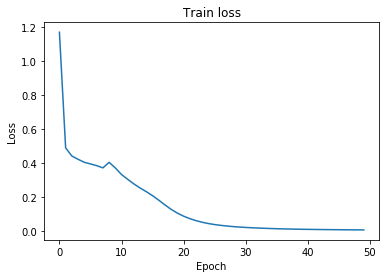

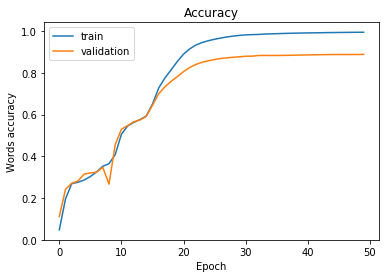

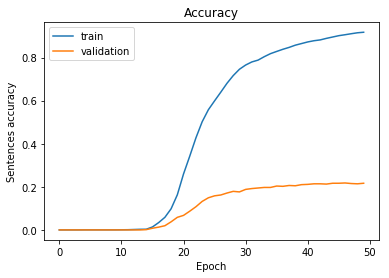

In [16]:
from matplotlib import pyplot as plt

plt.plot(train_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Train loss')
plt.show()

plt.plot(train_acc_word, label='train')
plt.plot(valid_acc_word, label = 'validation')
plt.ylabel('Words accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(train_acc_sent, label='train')
plt.plot(valid_acc_sent, label = 'validation')
plt.ylabel('Sentences accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()
plt.show()

## Asses model on test set

In [17]:
predictions = model.predict(test_data_indexed)
metrics = eval_one_hot(one_hot_test, predictions)
print(f'Accuracy per word {metrics[0]} per sentence {metrics[1]}')

Accuracy per word 0.8864682961388594 per sentence 0.20465890183028287


## Pipeline for further model usage

In [0]:
index_to_tag = {tag_to_index[k]:k for k in tag_to_index }

def predict_for_one(model, sentence):
  # split sentence by spaces
  sentence = sentence.split()
  # change word to their base forms
  sentence = [ word_forms_to_word.get(word, '-OOV-') for word in sentence]
  # convert sentence to numbers
  N = len(sentence)
  data_indexed = []
  for word in sentence:
    try:
      data_indexed.append(word_to_index[word])
    except KeyError:
      data_indexed.append(word_to_index['-OOV-'])
  # padding
  data_indexed = np.expand_dims(data_indexed, axis=0)
  data_indexed = pad_sequences(data_indexed, maxlen=MAX_LENGTH, padding='post')
  # get model predictions
  pred = model.predict(data_indexed)
  pred = np.argmax(pred, axis = -1)
  pred = pred[0][:N]
  # convert to human readable
  return [index_to_tag[i] for i in pred ]

## Example of model prediction (with mistake)

In [19]:
pred = predict_for_one(model, 'Райс написал этот роман в 1973 году , а впервые он быть напечатан в 1976 .')
true_tags = ['PROPN', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'PUNCT', 'CCONJ', 'ADV', 'PRON', 'AUX', 'VERB', 'ADP', 'ADJ', 'PUNCT']
print(f'Predicted tags {pred}')

Predicted tags ['NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'PUNCT', 'CCONJ', 'ADV', 'PRON', 'AUX', 'VERB', 'ADP', 'ADJ', 'PUNCT']


## Example of correct model prediction

In [20]:
pred = predict_for_one(model, 'Участник гражданской войны .')
true_tags = ['NOUN', 'ADJ', 'NOUN', 'PUNCT']
print(f'Predicted tags {pred}')

Predicted tags ['NOUN', 'ADJ', 'NOUN', 'PUNCT']


In [0]:
# test_text, y_test = [], []

# f = open(PATH_TO_TEST_DATA)
# line = f.readline()

# def process_test_line(line):
#   l = line.split()
#   word, tag = l[2], l[3]
#   sentence_data.append(word)
#   sentence_tags.append(tag)
  
# sentence_data, sentence_tags = [], []
# while line:
#   if ('sent_id' in line) or ('text' in line) or len(line)<4:
#     if len(sentence_data)>0:
#       test_text.append(sentence_data)
#       y_test.append(sentence_tags)
#     sentence_data, sentence_tags = [], []
#   else: 
#     process_test_line(line)
#   line = f.readline()
  
# f.close()

# for sentence, tag in zip(test_text, y_test): 
#   s = ' '.join(sentence)
#   pred = predict_for_one(model, s)
  
#   if pred == tag:
#     print(s)
#     print(tag)
#     print(pred)
#     print('ok')

## Analize model mistakes

In [22]:
def find_mistakes(y_true, y_pred):
  """
  return matrix of mistakes
  """
  y_true_class = np.argmax(y_true, axis = -1)
  y_pred_class = np.argmax(y_pred, axis = -1)
  n = len(tag_to_index)
  mistakes = np.zeros((n,n)) # следва true справа predicted

  # for every snetence
  for i in range(y_true_class.shape[0]):
    try:
      idx = np.where(y_true_class[i] == 0)[0][0]
    except IndexError:
      idx = len(y_true_class[i])
    
    for t, p in zip(y_true_class[i][:idx], y_pred_class[i][:idx]): 
      if t != p:
        mistakes[t,p] += 1
  
  return mistakes

predictions = model.predict(test_data_indexed)
mistakes = find_mistakes(one_hot_test, predictions)

# fimd most common mistakes
idx = np.where(mistakes > np.argmax(mistakes)/4)
idx_true, idx_pred = idx[0], idx[1] 

# convert to human readable
true_tags = [index_to_tag[i] for i in idx_true]
pred_tags = [index_to_tag[i] for i in idx_pred]

for i in range(len(true_tags)):
  n, m = idx_true[i], idx_pred[i]
  print(f'true tag {true_tags[i]} was taken by the model as {pred_tags[i]} {mistakes[n,m]} times')



true tag NOUN was taken by the model as PROPN 19.0 times
true tag NOUN was taken by the model as ADJ 35.0 times
true tag NOUN was taken by the model as NUM 85.0 times
true tag NOUN was taken by the model as X 25.0 times
true tag PROPN was taken by the model as NOUN 358.0 times
true tag PROPN was taken by the model as NUM 50.0 times
true tag PROPN was taken by the model as X 46.0 times
true tag VERB was taken by the model as NOUN 110.0 times
true tag VERB was taken by the model as NUM 34.0 times
true tag ADJ was taken by the model as NOUN 105.0 times
true tag ADJ was taken by the model as NUM 110.0 times
true tag PART was taken by the model as CCONJ 22.0 times
true tag NUM was taken by the model as NOUN 19.0 times
true tag ADV was taken by the model as NOUN 21.0 times
true tag X was taken by the model as NOUN 52.0 times
true tag X was taken by the model as NUM 38.0 times


## Analize correct predictions

In [23]:
def find_correct(y_true, y_pred):
  """
  return matrix of correctly classified
  """
  y_true_class = np.argmax(y_true, axis = -1)
  y_pred_class = np.argmax(y_pred, axis = -1)
  n = len(tag_to_index)
  corrects = np.zeros((n,n)) # следва true справа predicted
  

  # for every snetence
  for i in range(y_true_class.shape[0]):
    try:
      idx = np.where(y_true_class[i] == 0)[0][0]
    except IndexError:
      idx = len(y_true_class[i])
    
    for t, p in zip(y_true_class[i][:idx], y_pred_class[i][:idx]): 
      if t == p:
        corrects[t,p] += 1
  
  return corrects

predictions = model.predict(test_data_indexed)
corrects = find_correct(one_hot_test, predictions)

# fimd most common correct prediction
idx = np.where(corrects > np.argmax(corrects)/2)
idx_true, idx_pred = idx[0], idx[1] 

# convert to human readable
true_tags = [index_to_tag[i] for i in idx_true]
pred_tags = [index_to_tag[i] for i in idx_pred]

for i in range(len(true_tags)):
  n, m = idx_true[i], idx_pred[i]
  print(f'true tag {true_tags[i]} was guessed {corrects[n,m]} times')

true tag ADP was guessed 1253.0 times
true tag NOUN was guessed 2912.0 times
true tag PROPN was guessed 291.0 times
true tag CCONJ was guessed 327.0 times
true tag PUNCT was guessed 2044.0 times
true tag PRON was guessed 203.0 times
true tag VERB was guessed 833.0 times
true tag DET was guessed 191.0 times
true tag ADJ was guessed 1233.0 times
true tag SCONJ was guessed 51.0 times
true tag AUX was guessed 102.0 times
true tag PART was guessed 101.0 times
true tag NUM was guessed 173.0 times
true tag ADV was guessed 211.0 times
true tag X was guessed 71.0 times


## Experiment with different size of training data: 10%, 20% ... 90% and report accuracy for each set. 

In [24]:
# 10%
model = create_model()
X_train, _, y_train, __= train_test_split(train_data_indexed, train_labels_indexed, test_size=0.9)
one_hot_train = to_categorical(y_train, len(tag_to_index))
train(model, X_train, one_hot_train, epochs = EPOCHS, verbose = False)
predictions = model.predict(test_data_indexed)
metrics = eval_one_hot(one_hot_test, predictions)
print(f'10% training data accuracy per word: {metrics[0]} per sentence {metrics[1]}')

# 20%
model = create_model()
X_train, _, y_train, __= train_test_split(train_data_indexed, train_labels_indexed, test_size=0.8)
one_hot_train = to_categorical(y_train, len(tag_to_index))
train(model, X_train, one_hot_train, epochs = EPOCHS, verbose = False)
predictions = model.predict(test_data_indexed)
metrics = eval_one_hot(one_hot_test, predictions)
print(f'20% training data accuracy per word: {metrics[0]} per sentence {metrics[1]}')

# 30%
model = create_model()
X_train, _, y_train, __= train_test_split(train_data_indexed, train_labels_indexed, test_size=0.7)
one_hot_train = to_categorical(y_train, len(tag_to_index))
train(model, X_train, one_hot_train, epochs = EPOCHS, verbose = False)
predictions = model.predict(test_data_indexed)
metrics = eval_one_hot(one_hot_test, predictions)
print(f'30% training data accuracy per word: {metrics[0]} per sentence {metrics[1]}')

# 40%
model = create_model()
X_train, _, y_train, __= train_test_split(train_data_indexed, train_labels_indexed, test_size=0.6)
one_hot_train = to_categorical(y_train, len(tag_to_index))
train(model, X_train, one_hot_train, epochs = EPOCHS, verbose = False)
predictions = model.predict(test_data_indexed)
metrics = eval_one_hot(one_hot_test, predictions)
print(f'40% training data accuracy per word: {metrics[0]} per sentence {metrics[1]}')

# 50%
model = create_model()
X_train, _, y_train, __= train_test_split(train_data_indexed, train_labels_indexed, test_size=0.5)
one_hot_train = to_categorical(y_train, len(tag_to_index))
train(model, X_train, one_hot_train, epochs = EPOCHS, verbose = False)
predictions = model.predict(test_data_indexed)
metrics = eval_one_hot(one_hot_test, predictions)
print(f'50% training data accuracy per word: {metrics[0]} per sentence {metrics[1]}')

# 60%
model = create_model()
X_train, _, y_train, __= train_test_split(train_data_indexed, train_labels_indexed, test_size=0.4)
one_hot_train = to_categorical(y_train, len(tag_to_index))
train(model, X_train, one_hot_train, epochs = EPOCHS, verbose = False)
predictions = model.predict(test_data_indexed)
metrics = eval_one_hot(one_hot_test, predictions)
print(f'60% training data accuracy per word: {metrics[0]} per sentence {metrics[1]}')

# 70%
model = create_model()
X_train, _, y_train, __= train_test_split(train_data_indexed, train_labels_indexed, test_size=0.3)
one_hot_train = to_categorical(y_train, len(tag_to_index))
train(model, X_train, one_hot_train, epochs = EPOCHS, verbose = False)
predictions = model.predict(test_data_indexed)
metrics = eval_one_hot(one_hot_test, predictions)
print(f'70% training data accuracy per word: {metrics[0]} per sentence {metrics[1]}')

# 80%
model = create_model()
X_train, _, y_train, __= train_test_split(train_data_indexed, train_labels_indexed, test_size=0.2)
one_hot_train = to_categorical(y_train, len(tag_to_index))
train(model, X_train, one_hot_train, epochs = EPOCHS, verbose = False)
predictions = model.predict(test_data_indexed)
metrics = eval_one_hot(one_hot_test, predictions)
print(f'80% training data accuracy per word: {metrics[0]} per sentence {metrics[1]}')

# 90%
model = create_model()
X_train, _, y_train, __= train_test_split(train_data_indexed, train_labels_indexed, test_size=0.1)
one_hot_train = to_categorical(y_train, len(tag_to_index))
train(model, X_train, one_hot_train, epochs = EPOCHS, verbose = False)
predictions = model.predict(test_data_indexed)
metrics = eval_one_hot(one_hot_test, predictions)
print(f'90% training data accuracy per word: {metrics[0]} per sentence {metrics[1]}')

10% training data accuracy per word: 0.2820580942260007 per sentence 0.0
20% training data accuracy per word: 0.6570138150903294 per sentence 0.02329450915141431
30% training data accuracy per word: 0.7857775416223876 per sentence 0.06655574043261231
40% training data accuracy per word: 0.8490967056323061 per sentence 0.129783693843594
50% training data accuracy per word: 0.8597236981934112 per sentence 0.15640599001663893
60% training data accuracy per word: 0.8655685441020191 per sentence 0.1480865224625624
70% training data accuracy per word: 0.8822174991144173 per sentence 0.18136439267886856
80% training data accuracy per word: 0.8927559334041799 per sentence 0.22296173044925124
90% training data accuracy per word: 0.8924017003188098 per sentence 0.2079866888519135


## Assemble model with external embeddings

In [25]:
# DATA PREPROCESSING
train_data_embedded = []
test_data_embedded = []

def process_train_line(line):
  l = line.split()
  word, word_form, tag = l[2], l[1], l[4]
  # embed data
  try:
    sentence_data.append(external_embeddings[word])
  except KeyError:
    sentence_data.append(np.zeros(EMB_LEN))
  
# PREPROCESS TRAIN DATA  
f = open(PATH_TO_TRAIN_DATA)
line = f.readline()
sentence_data = []
while line:
  if ('sent_id' in line) or ('text' in line) or len(line)<4:
    if len(sentence_data)>0:
      train_data_embedded.append(sentence_data)
    sentence_data = []
  else: 
    process_train_line(line)
  line = f.readline()
f.close()

# PREPROCESS TEST DATA
f = open(PATH_TO_TEST_DATA)
line = f.readline()
sentence_data = []
while line:
  if ('sent_id' in line) or ('text' in line) or len(line)<4:
    if len(sentence_data)>0:
      test_data_embedded.append(sentence_data)
    sentence_data = []
  else: 
    process_train_line(line)
  line = f.readline()
f.close()


train_data_embedded = pad_sequences(train_data_embedded, maxlen=MAX_LENGTH, padding='post')
test_data_embedded = pad_sequences(test_data_embedded, maxlen=MAX_LENGTH, padding='post')

X_train, X_valid, y_train, y_valid = train_test_split(train_data_embedded, train_labels_indexed, test_size=0.2)

# one-hot encode the tags labels
one_hot_train = to_categorical(y_train, len(tag_to_index))
one_hot_valid = to_categorical(y_valid, len(tag_to_index))
one_hot_test = to_categorical(y_test, len(tag_to_index))


# network architecture
def create_model_2():  
  model = Sequential([
    InputLayer(input_shape=(MAX_LENGTH, EMB_LEN)), 
    Bidirectional(LSTM(256, return_sequences=True)), 
    Dense(TAG_VOCAB_SIZE),
    Activation('softmax')
  ])

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(LEARNING_RATE), metrics = ['accuracy'])
  
  return model

model = create_model_2()
train_loss, train_acc_word, valid_acc_word, train_acc_sent, valid_acc_sent = train(model, X_train, one_hot_train, X_valid, one_hot_valid, epochs=EPOCHS, verbose = True)

Epoch 0 train loss: 1.2712101793289186 train acc word: 0.023085042902550167 train acc sentence: 0.0  valid acc word: 0.03959200107368138 valid acc sentence: 0.0
Epoch 1 train loss: 0.611098153591156 train acc word: 0.15441555859106193 train acc sentence: 0.0  valid acc word: 0.17373506911823916 valid acc sentence: 0.0
Epoch 2 train loss: 0.553679827451706 train acc word: 0.18266662381643597 train acc sentence: 0.0  valid acc word: 0.18762582203731043 valid acc sentence: 0.0012970168612191958
Epoch 3 train loss: 0.4944103705883026 train acc word: 0.22262490042824873 train acc sentence: 0.0  valid acc word: 0.2405717353375386 valid acc sentence: 0.0012970168612191958
Epoch 4 train loss: 0.5519660699367523 train acc word: 0.16507091068544547 train acc sentence: 0.0  valid acc word: 0.15065091933968594 valid acc sentence: 0.0012970168612191958
Epoch 5 train loss: 0.5259973657131195 train acc word: 0.19777321319180224 train acc sentence: 0.0  valid acc word: 0.21923231780968996 valid acc se

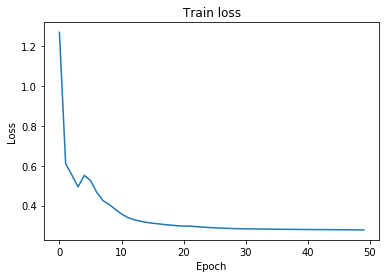

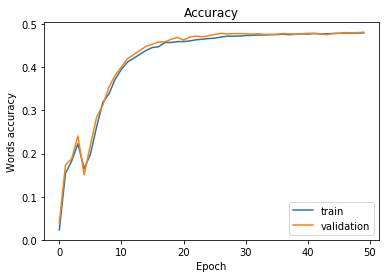

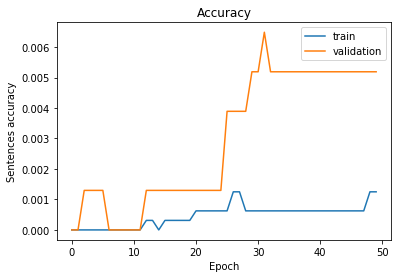

In [26]:
from matplotlib import pyplot as plt

plt.plot(train_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Train loss')
plt.show()

plt.plot(train_acc_word, label='train')
plt.plot(valid_acc_word, label = 'validation')
plt.ylabel('Words accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(train_acc_sent, label='train')
plt.plot(valid_acc_sent, label = 'validation')
plt.ylabel('Sentences accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()
plt.show()

## Evaluate model trained using external embeddings

In [27]:
predictions = model.predict(test_data_embedded)
metrics = eval_one_hot(one_hot_test, predictions)
print(f'Accuracy per word {metrics[0]} per sentence {metrics[1]}')

Accuracy per word 0.4807828551186681 per sentence 0.0066555740432612314
